# JCDS-1904 Zenio Rama
## Capstone 3 Travel Insurance Data 


 # Context
Travel insurance is a type of insurance that provides protection as long as we travel both domestically and abroad. Several countries have even required travelers to have travel insurance, for example, countries in Europe and America. The amount of premium depends on the coverage desired, the length of the trip, and the purpose of the trip. A company engaged in travel insurance wants to know the policyholder who will submit an insurance claim for coverage. Policyholder data at insurance companies is historical data consisting of destinations, insurance products, and so on.

 # Features
1. Agency: Name of agency.
2. Agency Type: Type of travel insurance agencies.
3. Distribution Channel: Channel of travel insurance agencies.
4. Product Name: Name of the travel insurance products.
5. Gender: Gender of insured.
6. Duration: Duration of travel.
7. Destination: Destination of travel.
8. Net Sales: Amount of sales of travel insurance policies.
9. Commission (in value): Commission received for travel insurance agency.
10. Age: Age of insured.
11.  Claim: Claim status.

In [1]:
# Library

import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import missingno
from IPython.display import display

# Feature Engineering
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
import category_encoders as ce

# Model Selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split, cross_val_score,RandomizedSearchCV,KFold
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score
from sklearn.metrics import roc_curve, roc_auc_score, plot_roc_curve

# Imbalance Dataset
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler

# Ignore Warning
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

# Set max columns
pd.set_option('display.max_columns', None)


In [2]:
df=pd.read_csv('data_travel_insurance.csv')
df.head()

,Agency,Agency Type,Distribution Channel,Product Name,Gender,Duration,Destination,Net Sales,Commision (in value),Age,Claim
0,C2B,Airlines,Online,Annual Silver Plan,F,365,SINGAPORE,216.0,54.0,57,No
1,EPX,Travel Agency,Online,Cancellation Plan,NaN,4,MALAYSIA,10.0,0.0,33,No
2,JZI,Airlines,Online,Basic Plan,M,19,INDIA,22.0,7.7,26,No
3,EPX,Travel Agency,Online,2 way Comprehensive Plan,NaN,20,UNITED STATES,112.0,0.0,59,No
4,C2B,Airlines,Online,Bronze Plan,M,8,SINGAPORE,16.0,4.0,28,No


In [3]:
 df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44328 entries, 0 to 44327
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Agency                44328 non-null  object 
 1   Agency Type           44328 non-null  object 
 2   Distribution Channel  44328 non-null  object 
 3   Product Name          44328 non-null  object 
 4   Gender                12681 non-null  object 
 5   Duration              44328 non-null  int64  
 6   Destination           44328 non-null  object 
 7   Net Sales             44328 non-null  float64
 8   Commision (in value)  44328 non-null  float64
 9   Age                   44328 non-null  int64  
 10  Claim                 44328 non-null  object 
dtypes: float64(2), int64(2), object(7)
memory usage: 3.7+ MB


<AxesSubplot:>

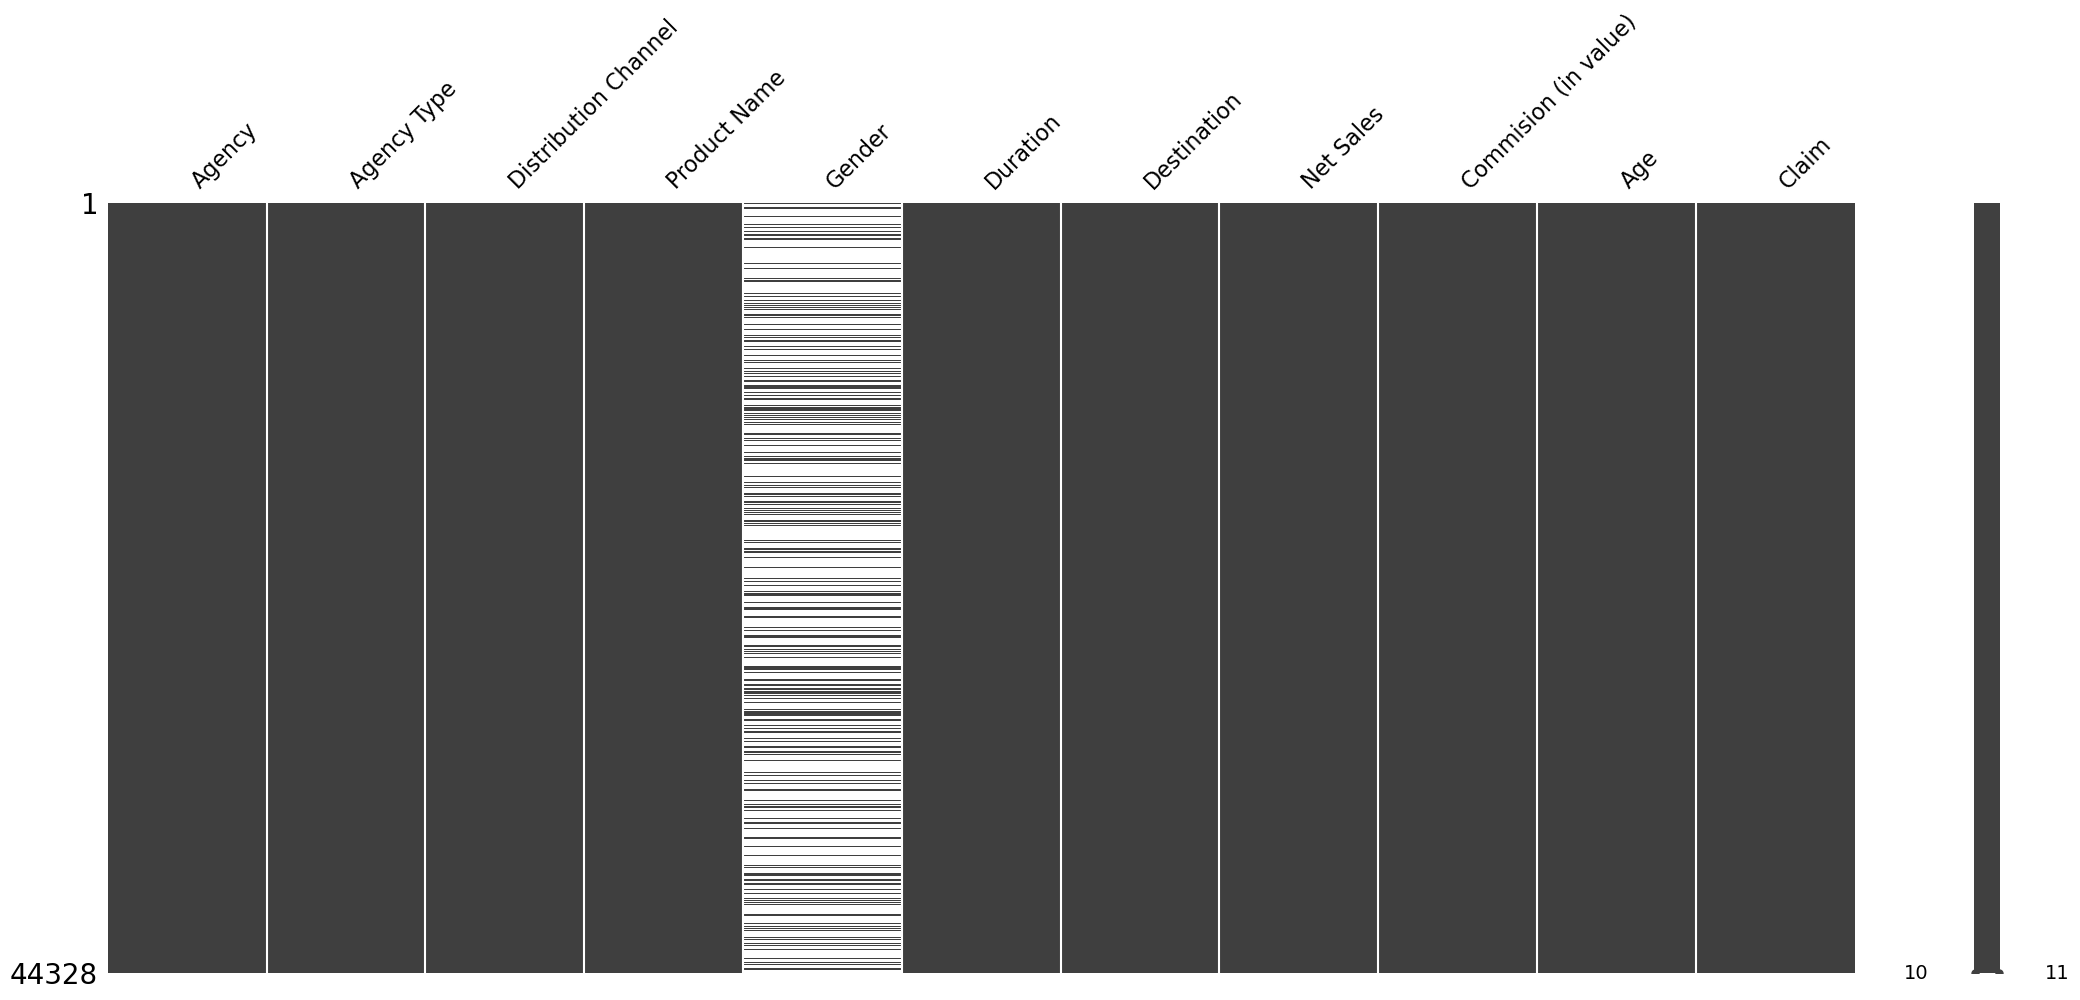

In [4]:
missingno.matrix(df)

In [5]:
df['Gender'].isna().sum()

31647

In [6]:
df.drop(['Gender'],axis=1, inplace=True)

In [7]:
df_numerical = df._get_numeric_data()
df_numerical.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44328 entries, 0 to 44327
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Duration              44328 non-null  int64  
 1   Net Sales             44328 non-null  float64
 2   Commision (in value)  44328 non-null  float64
 3   Age                   44328 non-null  int64  
dtypes: float64(2), int64(2)
memory usage: 1.4 MB


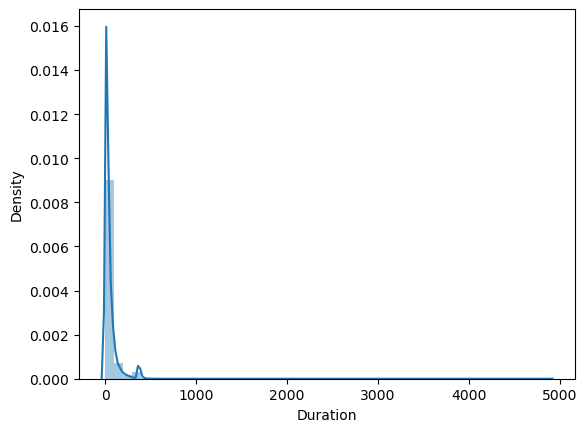

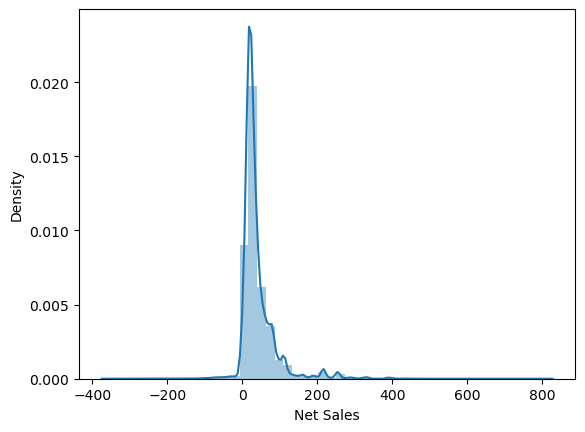

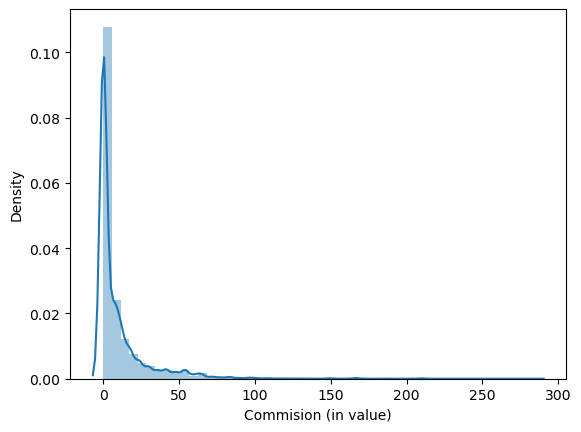

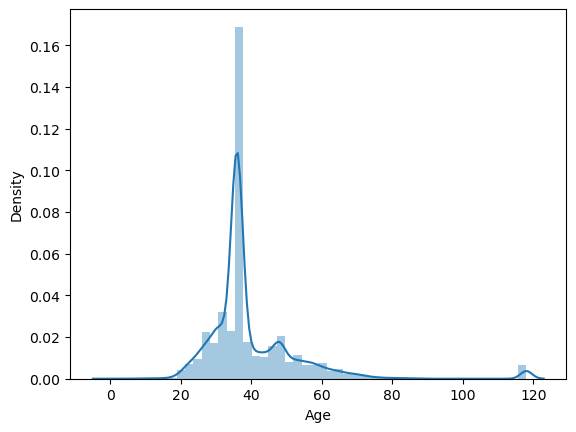

In [8]:
for i, col in enumerate(df_numerical.columns):
    plt.figure(i)
    sns.distplot(df_numerical[col])


In [9]:
df['Duration'].describe()

count    44328.000000
mean        49.424292
std        109.153961
min         -1.000000
25%          9.000000
50%         22.000000
75%         53.000000
max       4881.000000
Name: Duration, dtype: float64

Terlihat nilai min pada kolom durasi,dimana seharusnya durasi tidak bisa minus, tidak masuk akal

In [10]:
min_dur = df['Duration'] < 0
min_dur.sum()
 

2

ganti minus dengan rata-rata durasi

In [11]:
df.loc[df['Duration'] < 0, 'Duration'] = 49.424


In [12]:
df[df['Duration']==0].groupby(by='Claim')["Net Sales", "Commision (in value)"].sum()

,Net Sales,Commision (in value)
Claim,,
No,1173.73,477.24


terdapat juga durasi perjalanan 0, dimana terdengar tidak mungkin dengan status claim yang ditolak

In [13]:
len(df[df['Duration']==0])

47

Drop perjalanan dengan durasi 0

In [14]:
df.drop(index=df[df['Duration']==0].index.values, inplace = True)

<AxesSubplot:xlabel='Duration', ylabel='Count'>

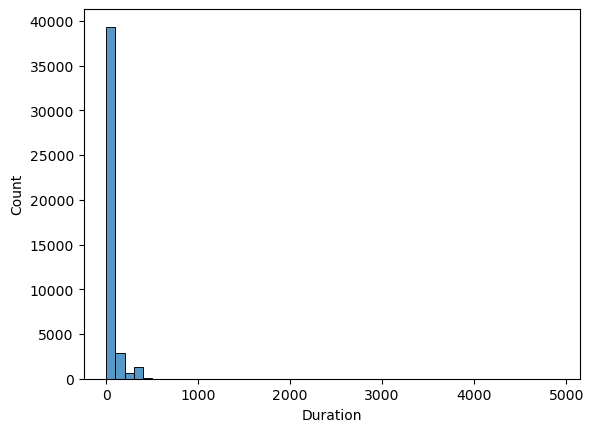

In [15]:
sns.histplot(data=df, x="Duration",binwidth=100)

[Text(0, 0, '123'),
 Text(0, 0, '0'),
 Text(0, 0, '0'),
 Text(0, 0, '0'),
 Text(0, 0, '0'),
 Text(0, 0, '0'),
 Text(0, 0, '0'),
 Text(0, 0, '0'),
 Text(0, 0, '13')]

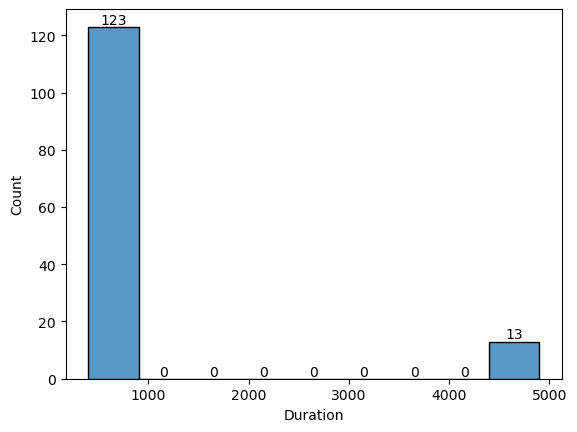

In [16]:
df_duration = df[df['Duration'] > 400]
ax = sns.histplot(data=df_duration, x="Duration",
                  binwidth=500)
ax.bar_label(ax.containers[0])


sepertinya data durasi lebih dari 400 merupakan kesalahan input, karena jumlahnya sangat sedikit, kita akan drop durasi yang terlihat tidak normal

In [17]:
df.drop(index=df[df['Duration']>400].index.values, inplace = True)

Berikutnya kita cek data duplicate

In [18]:
df.duplicated().sum()


4989

Terdapat sebanyak 4989 data duplicate, kita drop untuk menjadikan data persis satu satu

In [19]:
df=df.drop_duplicates()

In [20]:
# Cek kembali
print(f"Number of duplicated rows:  {df.duplicated().sum()}")


Number of duplicated rows:  0


Cek keselarasan antara Net sales dan komisi yang didapat

In [21]:
com = df['Net Sales'] < df['Commision (in value)']
com .sum()


1372

terdapat 1372 data komisi yang lebih dari net sales hal ini tidak mungkin

In [22]:
pd.crosstab(df['Agency'],df['Agency Type'],margins=True)

Agency Type,Airlines,Travel Agency,All
Agency,,,
ADM,0,55,55
ART,226,0,226
C2B,5248,0,5248
CBH,0,67,67
CCR,0,114,114
CSR,0,68,68
CWT,0,5723,5723
EPX,0,20990,20990
JWT,280,0,280


In [23]:
prod = pd.crosstab(df['Product Name'], df['Claim'], margins=True)
prod = (prod.div(prod['All'], axis=0))*100

prod['mean commision'] = df.groupby(
    'Product Name')['Commision (in value)'].mean()
prod.drop(index=['All'], inplace=True)
prod


Claim,No,Yes,All,mean commision
Product Name,,,,
1 way Comprehensive Plan,99.621212,0.378788,100.0,0.000000
2 way Comprehensive Plan,98.831919,1.168081,100.0,0.000000
24 Protect,100.000000,0.000000,100.0,8.612924
Annual Gold Plan,88.188976,11.811024,100.0,89.007874
Annual Silver Plan,86.597938,13.402062,100.0,57.270979
Annual Travel Protect Gold,86.538462,13.461538,100.0,162.464231
Annual Travel Protect Platinum,96.666667,3.333333,100.0,218.128667
Annual Travel Protect Silver,89.743590,10.256410,100.0,134.410256
Basic Plan,99.558986,0.441014,100.0,9.649118


In [24]:
df.describe()

,Duration,Net Sales,Commision (in value),Age
count,39156.000000,39156.000000,39156.000000,39156.000000
mean,49.590429,41.732582,10.166613,39.814767
std,71.277291,48.619368,19.787243,13.195131
min,1.000000,-357.500000,0.000000,0.000000
25%,11.000000,19.000000,0.000000,35.000000
50%,25.000000,29.000000,0.000000,36.000000
75%,56.000000,49.500000,11.880000,44.000000
max,400.000000,810.000000,283.500000,118.000000


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39156 entries, 0 to 44327
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Agency                39156 non-null  object 
 1   Agency Type           39156 non-null  object 
 2   Distribution Channel  39156 non-null  object 
 3   Product Name          39156 non-null  object 
 4   Duration              39156 non-null  float64
 5   Destination           39156 non-null  object 
 6   Net Sales             39156 non-null  float64
 7   Commision (in value)  39156 non-null  float64
 8   Age                   39156 non-null  int64  
 9   Claim                 39156 non-null  object 
dtypes: float64(3), int64(1), object(6)
memory usage: 3.3+ MB


Cek isi data dari setiap columns

In [26]:
column_keys = df.select_dtypes(include=['object']).columns.tolist()
for key in column_keys:
    print('Unique dari', key, 'ada : ')
    print(df[key].unique(), end='\n')
    print(end='\n')


Unique dari Agency ada : 
['C2B' 'EPX' 'JZI' 'CWT' 'LWC' 'ART' 'CSR' 'RAB' 'KML' 'SSI' 'TST' 'TTW'
 'JWT' 'ADM' 'CCR' 'CBH']

Unique dari Agency Type ada : 
['Airlines' 'Travel Agency']

Unique dari Distribution Channel ada : 
['Online' 'Offline']

Unique dari Product Name ada : 
['Annual Silver Plan' 'Cancellation Plan' 'Basic Plan'
 '2 way Comprehensive Plan' 'Bronze Plan' '1 way Comprehensive Plan'
 'Rental Vehicle Excess Insurance' 'Single Trip Travel Protect Gold'
 'Silver Plan' 'Value Plan' '24 Protect' 'Annual Travel Protect Gold'
 'Comprehensive Plan' 'Ticket Protector' 'Travel Cruise Protect'
 'Single Trip Travel Protect Silver' 'Individual Comprehensive Plan'
 'Gold Plan' 'Annual Gold Plan' 'Child Comprehensive Plan' 'Premier Plan'
 'Single Trip Travel Protect Platinum' 'Annual Travel Protect Silver'
 'Annual Travel Protect Platinum' 'Spouse or Parents Comprehensive Plan'
 'Travel Cruise Protect Family']

Unique dari Destination ada : 
['SINGAPORE' 'MALAYSIA' 'INDIA' 'UNITED 

In [27]:
df['Destination'].sort_values(ascending=False).unique()


array(['ZIMBABWE', 'ZAMBIA', 'VIET NAM', 'VENEZUELA', 'VANUATU',
       'UZBEKISTAN', 'URUGUAY', 'UNITED STATES', 'UNITED KINGDOM',
       'UNITED ARAB EMIRATES', 'UKRAINE', 'UGANDA', 'TURKMENISTAN',
       'TURKEY', 'TUNISIA', 'TRINIDAD AND TOBAGO', 'TIBET', 'THAILAND',
       'TANZANIA, UNITED REPUBLIC OF', 'TAJIKISTAN',
       'TAIWAN, PROVINCE OF CHINA', 'SWITZERLAND', 'SWEDEN', 'SRI LANKA',
       'SPAIN', 'SOUTH AFRICA', 'SLOVENIA', 'SINGAPORE', 'SERBIA',
       'SENEGAL', 'SAUDI ARABIA', 'SAMOA', 'RWANDA', 'RUSSIAN FEDERATION',
       'ROMANIA', 'REUNION', 'REPUBLIC OF MONTENEGRO', 'QATAR',
       'PUERTO RICO', 'PORTUGAL', 'POLAND', 'PHILIPPINES', 'PERU',
       'PAPUA NEW GUINEA', 'PANAMA', 'PAKISTAN', 'OMAN', 'NORWAY',
       'NORTHERN MARIANA ISLANDS', 'NIGERIA', 'NEW ZEALAND',
       'NETHERLANDS', 'NEPAL', 'NAMIBIA', 'MYANMAR', 'MOROCCO',
       'MONGOLIA', 'MOLDOVA, REPUBLIC OF', 'MEXICO', 'MAURITIUS', 'MALTA',
       'MALI', 'MALDIVES', 'MALAYSIA',
       'MACEDONIA, THE

Terdapat kesalahan penulisan destinasi pada vietnam 

In [28]:
df['Destination'].replace({'VIET NAM':'VIETNAM'},inplace=True)

Cek distribusi claims

Text(0.5, 1.0, 'Distribution of Claims')

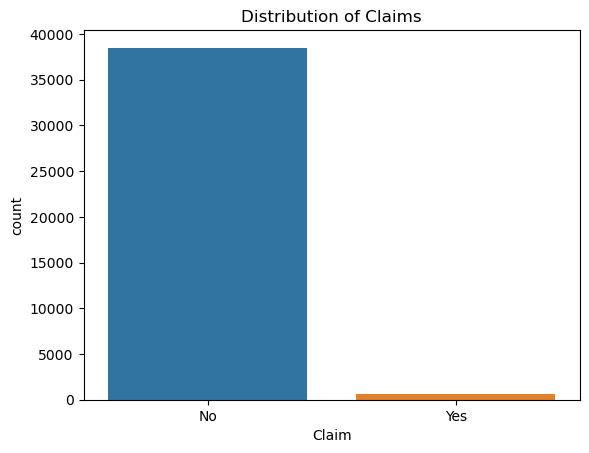

In [29]:

sns.countplot(x=df["Claim"]).set_title("Distribution of Claims")


terlihat data sangat imbalance claim dengan tidak

In [30]:
df['Claim'].unique()

array(['No', 'Yes'], dtype=object)

<AxesSubplot:>

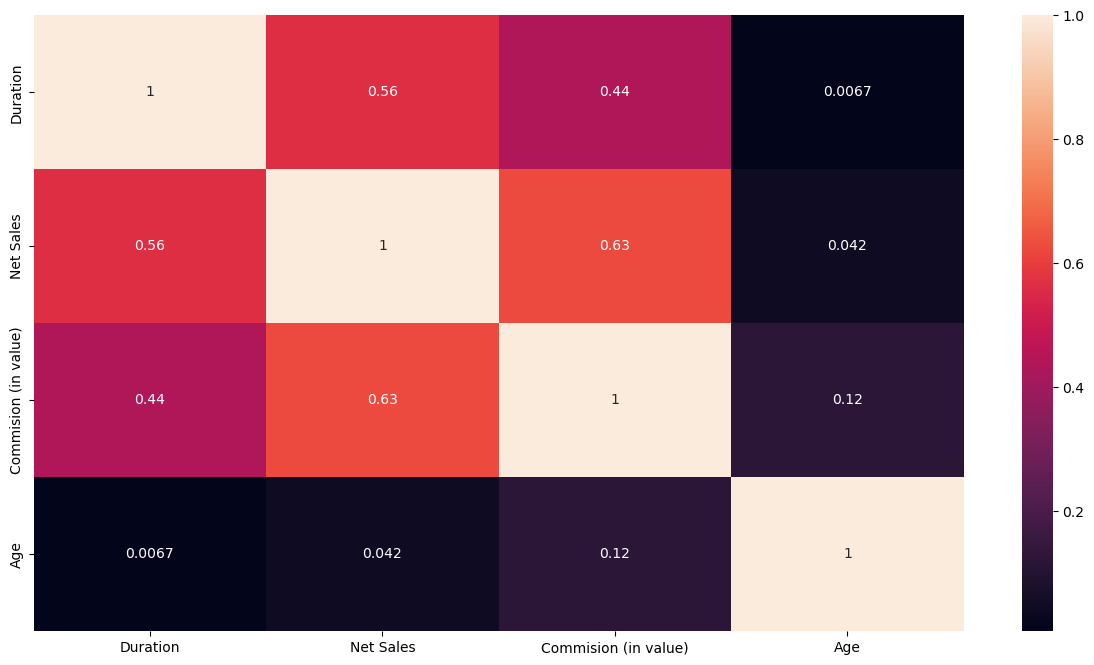

In [31]:
plt.figure(figsize=[15,8])
sns.heatmap(df.corr(),annot = True)

# Preprocesing

In [33]:
from sklearn import preprocessing

In [34]:
df.columns

Index(['Agency', 'Agency Type', 'Distribution Channel', 'Product Name',
       'Duration', 'Destination', 'Net Sales', 'Commision (in value)', 'Age',
       'Claim'],
      dtype='object')

Menggunakan Label Encoder untuk mengubah data kategorikal

In [35]:
label_encoder1 = preprocessing.LabelEncoder()
df['Agency']= label_encoder1.fit_transform(df['Agency'])
  
label_encoder2 = preprocessing.LabelEncoder()
df['Agency Type']= label_encoder2.fit_transform(df['Agency Type'])

label_encoder3 = preprocessing.LabelEncoder()
df['Distribution Channel']= label_encoder3.fit_transform(df['Distribution Channel'])

label_encoder4 = preprocessing.LabelEncoder()
df['Product Name']= label_encoder4.fit_transform(df['Product Name'])

label_encoder5 = preprocessing.LabelEncoder()
df['Claim']= label_encoder5.fit_transform(df['Claim'])


label_encoder6 = preprocessing.LabelEncoder()
df['Destination']= label_encoder6.fit_transform(df['Destination'])

In [36]:
df

,Agency,Agency Type,Distribution Channel,Product Name,Duration,Destination,Net Sales,Commision (in value),Age,Claim
0,2,0,1,4,365.0,110,216.0,54.00,57,0
1,7,1,1,10,4.0,74,10.0,0.00,33,0
2,9,0,1,8,19.0,52,22.0,7.70,26,0
3,7,1,1,1,20.0,130,112.0,0.00,59,0
4,2,0,1,9,8.0,110,16.0,4.00,28,0
...,...,...,...,...,...,...,...,...,...,...
44323,7,1,1,1,14.0,23,30.0,0.00,36,1
44324,6,1,1,16,17.0,3,79.2,47.52,47,0
44325,14,1,0,23,64.0,120,30.0,10.50,50,0
44326,7,1,1,1,51.0,23,36.0,0.00,36,0


In [37]:
column_names = ["Agency", "Agency Type", "Distribution Channel", "Product Name",
                "Duration", "Destination", "Net Sales", "Commision (in value)", "Age", "Claim"]
df = df.reindex(columns=column_names)


In [38]:
y=df.iloc[:,[-1]]
x=df.drop(y.columns,axis = 1)

Memberikan Treatment SMOTE untuk imbalance data

In [39]:
from imblearn.over_sampling import SMOTE


In [40]:
sm = SMOTE(random_state=42)
x_sm, y_sm = sm.fit_resample(x, y)
print(f'''Shape of X before SMOTE: {x.shape}
Shape of X after SMOTE: {x_sm.shape}''')
print('\nBalance of positive and negative classes (%):')
y_sm.value_counts(normalize=True) * 100


Shape of X before SMOTE: (39156, 9)
Shape of X after SMOTE: (76976, 9)

Balance of positive and negative classes (%):


Claim
0        50.0
1        50.0
dtype: float64

In [41]:
from sklearn.preprocessing import MinMaxScaler



menggunakan minmax scaller untuk scalling data agar rentang dataset menjadi lebih kecil

In [42]:
X_new = pd.DataFrame()
to_scale = x_sm.columns
mms = MinMaxScaler()
X_new[to_scale] = mms.fit_transform(x_sm[to_scale])
X_new.head()

,Agency,Agency Type,Distribution Channel,Product Name,Duration,Destination,Net Sales,Commision (in value),Age
0,0.133333,0.0,1.0,0.16,0.912281,0.802920,0.491221,0.190476,0.483051
1,0.466667,1.0,1.0,0.40,0.007519,0.540146,0.314775,0.000000,0.279661
2,0.600000,0.0,1.0,0.32,0.045113,0.379562,0.325054,0.027160,0.220339
3,0.466667,1.0,1.0,0.04,0.047619,0.948905,0.402141,0.000000,0.500000
4,0.133333,0.0,1.0,0.36,0.017544,0.802920,0.319914,0.014109,0.237288


Splitting

In [43]:
xtrain, xtest, ytrain, ytest = train_test_split(X_new, y_sm, test_size=0.25, random_state=42)


## Model Benchmarking

Mencari model terbaik yang akan digunakan untuk prediksi. 

## Random Forest

In [44]:
forest = RandomForestClassifier(random_state=42)
forest.fit(xtrain, ytrain)
pred = forest.predict(xtest)


In [45]:
print(f'Accuracy = {accuracy_score(ytest, pred):.2f}\nRecall = {recall_score(ytest, pred)}\n')



Accuracy = 0.97
Recall = 0.9801835627868168



In [46]:
f1_score(ytest, pred, average='macro')


0.9734979581273118

## XGB CLASS

In [47]:
xgb = XGBClassifier()
xgb.fit(xtrain, ytrain)
predxgb = xgb.predict(xtest)


In [48]:
xgbp=print(f'Accuracy = {accuracy_score(ytest, predxgb):.2f}\nRecall = {recall_score(ytest, predxgb):.2f}\n')


Accuracy = 0.97
Recall = 0.97



## KNN

In [49]:
knn = KNeighborsClassifier (n_neighbors=5)
knn.fit(xtrain, ytrain)
predknn = knn.predict(xtest)


In [51]:
print(f'Accuracy = {accuracy_score(ytest, predknn):.2f}\nRecall = {recall_score(ytest, predknn):.2f}\n')

Accuracy = 0.93
Recall = 0.98



# TREE

In [52]:
Tree = DecisionTreeClassifier(criterion='entropy', max_depth=5)
Tree.fit(xtrain, ytrain)
predtree = Tree.predict(xtest)


In [53]:
print(f'Accuracy = {accuracy_score(ytest, predtree):.2f}\nRecall = {recall_score(ytest, predtree):.2f}\n')


Accuracy = 0.79
Recall = 0.71



## LogReg

In [54]:
logreg = LogisticRegression(solver='liblinear')
logreg.fit(xtrain, ytrain)
predlogreg = logreg.predict(xtest)


In [55]:
print(f'Accuracy = {accuracy_score(ytest, predlogreg):.2f}\nRecall = {recall_score(ytest, predlogreg):.2f}\n')


Accuracy = 0.78
Recall = 0.73



Dari Benchmark diatas yang sudah dicoba secara manual, dengan scoring Recall tertinggi didapatkan oleh model Random Forest. 

In [57]:
from jcopml.tuning import grid_search_params as gsp

In [58]:
gsp.rf_params

{'algo__n_estimators': [100, 150, 200],
 'algo__max_depth': [20, 50, 80],
 'algo__max_features': [0.3, 0.6, 0.8],
 'algo__min_samples_leaf': [1, 5, 10]}

In [59]:
params = {'n_estimators': [100, 150, 200],
          'max_depth': [20, 50, 80],
          'max_features': [0.3, 0.6, 0.8],
          'min_samples_leaf': [1, 5, 10]}


In [60]:
kf = KFold(n_splits=4)

In [61]:
rf_rs = RandomizedSearchCV(forest,params,cv=kf,n_jobs=-1,verbose=1,scoring='recall',n_iter=300,random_state=42)

In [62]:
rf_rs.fit(xtrain,ytrain)

Fitting 4 folds for each of 81 candidates, totalling 324 fits


RandomizedSearchCV(cv=KFold(n_splits=4, random_state=None, shuffle=False),
                   estimator=RandomForestClassifier(random_state=42),
                   n_iter=300, n_jobs=-1,
                   param_distributions={'max_depth': [20, 50, 80],
                                        'max_features': [0.3, 0.6, 0.8],
                                        'min_samples_leaf': [1, 5, 10],
                                        'n_estimators': [100, 150, 200]},
                   random_state=42, scoring='recall', verbose=1)

In [63]:
print('best tuning score :',rf_rs.best_score_)
print('best params :', rf_rs.best_params_)
rf_tuned_1 = rf_rs.best_estimator_

best tuning score : 0.9811498426723457
best params : {'n_estimators': 200, 'min_samples_leaf': 1, 'max_features': 0.6, 'max_depth': 20}


Didapatkan parameter terbaik setelah dilakukan proses tuning, dengan nilai diatas

In [64]:
forest_tuned = RandomForestClassifier(n_estimators=200,min_samples_leaf=1,max_features=0.6,max_depth=20)
forest_tuned.fit(xtrain, ytrain)
pred_after = forest_tuned.predict(xtest)

In [65]:
print(f'Recall_before = {recall_score(ytest, pred)}\n')
print(f'Recall_after= {recall_score(ytest, pred_after)}\n')

Recall_before = 0.9801835627868168

Recall_after= 0.9843554443053817



Terdapat kenaikan pada nilai Recall sebesar 0.0043 setelah dilakukan hyperparameter tuning pada model random forest.

Text(70.72222222222221, 0.5, 'True Label')

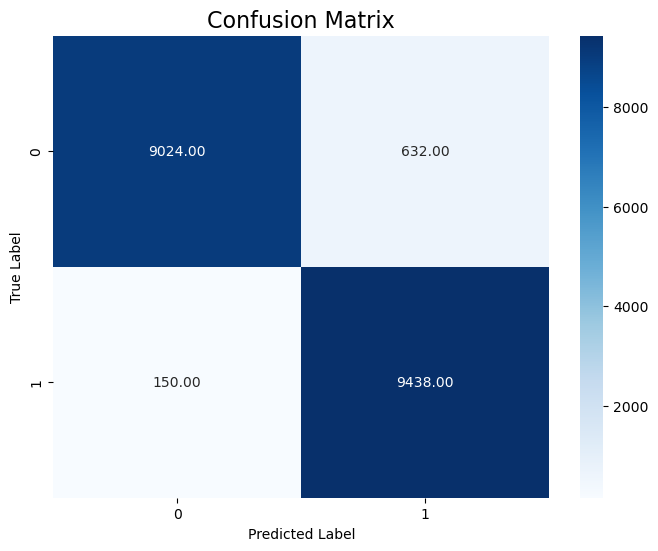

In [66]:
cm = confusion_matrix(ytest, pred_after)
plt.figure(figsize=(8, 6))
plt.title('Confusion Matrix', size=16)
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')


## Kesimpulan
* dari percobaan model diatas model terbaik yang digunakan untuk memprediksi claim adalah Random Forest dengan nilai akurasi sebesar 0.97, dan nilai recall yang telah di tuning sebesar 0.098433
* Pada confusion matrix terdapat setidaknya 150 orang yang diprediksi tidak claim tetapi claim dalam hal ini merupakan kelas FALSE NEGATIVE yang dimana dapat merugikan, angka hasil prediksi ini berguna untuk memberikan perusahaan asuransi data siaga untuk mencegah claim yang tidak terduga dari pelanggan asuransi travel

# Saran
**Untuk mengurangi nilai false negative dengan claim asuransi sebagai nilai positif, beberapa rekomendasi yang dapat dilakukan antara lain:**

* Menggunakan model prediksi yang lebih baik dengan mengoptimalkan parameter, mengubah model yang digunakan, atau menggunakan teknik lain seperti ensemble learning atau deep learning untuk meningkatkan performa prediksi.

* Melakukan peningkatan pada proses klaim dengan mempercepat waktu penyelesaian klaim, memberikan dukungan pelanggan yang lebih baik, dan membuat proses klaim lebih mudah dan transparan bagi pelanggan.

* Melakukan pemilihan strategi marketing yang tepat agar lebih menarik bagi pelanggan yang berisiko rendah untuk mengajukan klaim. Hal ini akan membantu memperkecil kemungkinan terjadinya false negative

In [67]:
import pickle as pickle

In [68]:
with open('forest_tuned.pkl', 'wb') as file:
    pickle.dump(forest_tuned,file)
